In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE


c:\Users\MidAutumnFestival\.conda\envs\hw6\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\MidAutumnFestival\.conda\envs\hw6\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

`1) Load the Apple-To-Oranges Dataset using tensorflow.`

In [2]:
# Storing the training images into a specific path
if not os.path.exists('a_train'):
    os.mkdir('a_train')
    
if not os.path.exists('b_train'):
    os.mkdir('b_train')

if os.path.exists('trainA'):
    os.rename('trainA', './a_train/Apple')
    

if os.path.exists('trainB'):
    os.rename('trainB', './b_train/Orange')

In [3]:
# Storing the testing images into a specific path
if not os.path.exists('a_test'):
    os.mkdir('a_test')
    
if not os.path.exists('b_test'):
    os.mkdir('b_test')

if os.path.exists('testA'):
    os.rename('testA', './a_test/Apple')
    

if os.path.exists('testB'):
    os.rename('testB', './b_test/Orange')

In [4]:
input_img_size = (256, 256, 3)
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1

def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def preprocess_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


In [5]:
def img_from_dir_wrapper(path, batch_size=32, image_size=(256, 256), val=False):
    if val:
        return tf.keras.preprocessing.image_dataset_from_directory(
            path,
            validation_split=0.2,
            subset='both',
            seed=2023,
            image_size=image_size,
            batch_size=batch_size,
            crop_to_aspect_ratio=True)
    else:
        return tf.keras.preprocessing.image_dataset_from_directory(
            path,
            image_size=image_size,
            batch_size=batch_size,
            crop_to_aspect_ratio=True)

In [6]:
apple_train_ds = img_from_dir_wrapper('a_train', batch_size=1)

apple_train_ds = (
    apple_train_ds.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
)

Found 995 files belonging to 1 classes.


In [7]:
orange_train_ds = img_from_dir_wrapper('b_train', batch_size=1)

orange_train_ds = (
    orange_train_ds.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
)

Found 1019 files belonging to 1 classes.


In [8]:
apple_test_ds = img_from_dir_wrapper('a_test', batch_size=1)

apple_test_ds = (
    apple_test_ds.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
)

Found 266 files belonging to 1 classes.


In [9]:
orange_test_ds = img_from_dir_wrapper('b_test', batch_size=1)

orange_test_ds = (
    orange_test_ds.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
)

Found 248 files belonging to 1 classes.


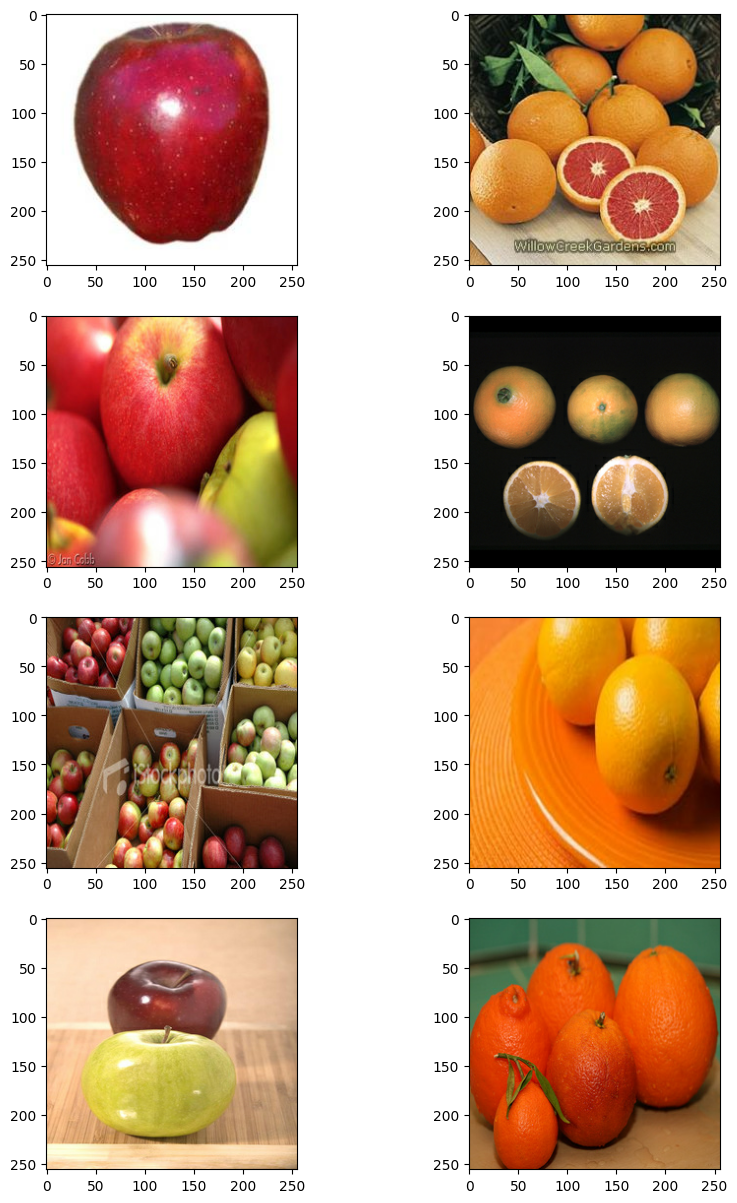

In [10]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(apple_train_ds.take(4), orange_train_ds.take(4))):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()


`2) Create and train Cycle GAN on this dataset for at least 1 epoch.`

In [11]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [12]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


In [13]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")


c:\Users\MidAutumnFestival\.conda\envs\hw6\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (
            self.disc_X(inputs),
            self.disc_Y(inputs),
            self.gen_G(inputs),
            self.gen_F(inputs),
        )

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }


In [15]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(apple_test_ds.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

995/995 [==============================] - ETA: 0s - G_loss: 5.3201 - F_loss: 5.0569 - D_X_loss: 0.1323 - D_Y_loss: 0.1617

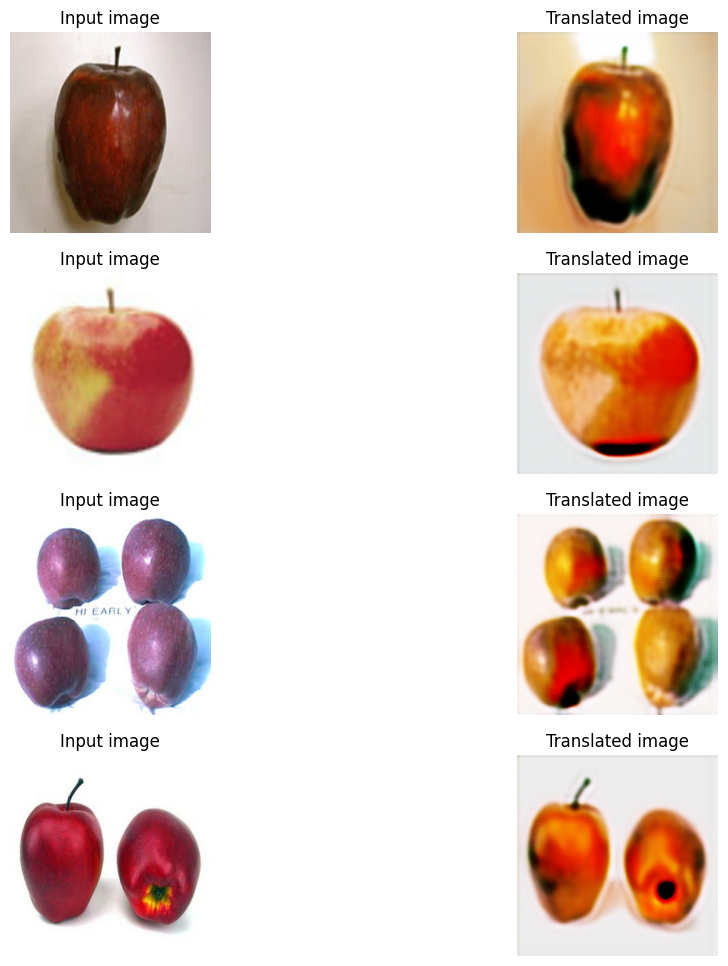

995/995 [==============================] - 573s 536ms/step - G_loss: 5.3180 - F_loss: 5.0550 - D_X_loss: 0.1323 - D_Y_loss: 0.1617


In [16]:
adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

plotter = GANMonitor()

cycle_gan_model.fit(
    tf.data.Dataset.zip((apple_train_ds, orange_train_ds)),
    epochs=1,
    callbacks=[
        plotter,],
)

`3) Show your results( Few converted images).`

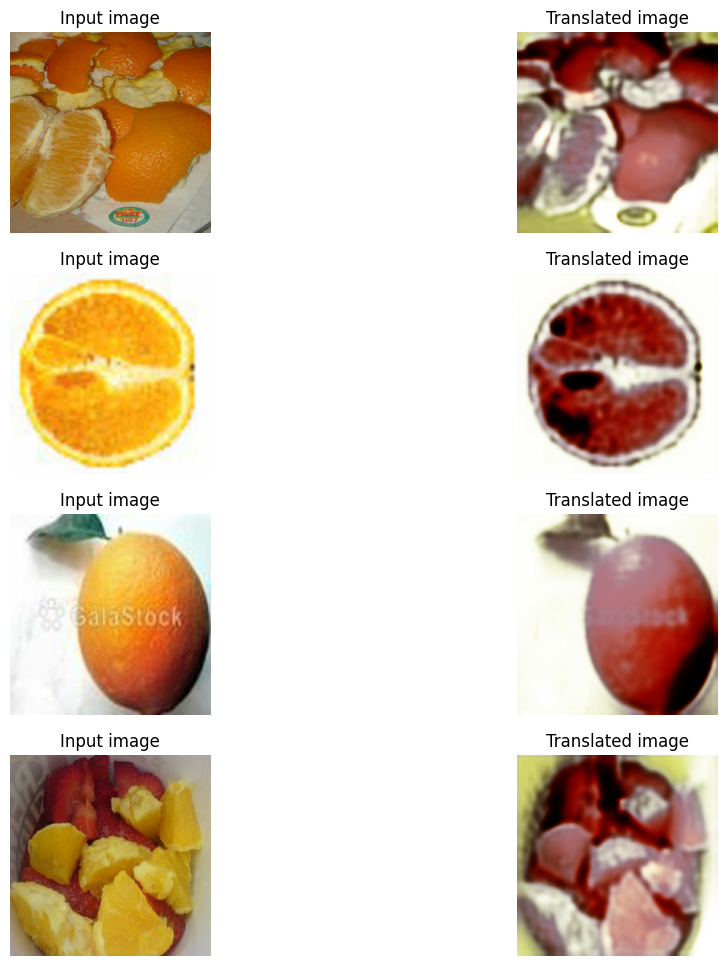

In [17]:
_, ax = plt.subplots(4, 2, figsize=(12, 12))
for i, img in enumerate(orange_test_ds.take(4)):
    prediction = gen_F(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.show()
plt.close()

`4) load your favorite image (or your picture) and apply Cyclegan and upload with the report. `

In [42]:
# Storing the image into a specific path
if not os.path.exists('own_image'):
    os.mkdir('own_image')
    os.mkdir('own_image/person')
    os.rename('ChungHonLam.jpeg', 'own_image/person/ChungHonLam.jpeg')

In [43]:
own_ds = img_from_dir_wrapper('own_image', batch_size=1)

own_ds = (
    own_ds.map(preprocess_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
)

Found 1 files belonging to 1 classes.


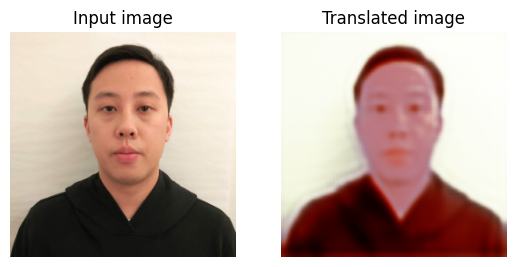

In [47]:
_, ax = plt.subplots(1, 2)
for i, img in enumerate(own_ds):
    prediction = gen_F(img)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0].imshow(img)
    ax[1].imshow(prediction)
    ax[0].set_title("Input image")
    ax[1].set_title("Translated image")
    ax[0].axis("off")
    ax[1].axis("off")
    
    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save(
        "generated_owm_img.png"
    )

plt.show()
plt.close()